In [1]:
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch import nn

In [2]:
#device agonistic code
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
n_samples=1000
X,y=make_circles(n_samples,noise=0.03, random_state=42)

print(f"First 5 X feature:\n{X[:5]}")
print(f"First 5 y labels:\n{y[:5]}")

First 5 X feature:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 y labels:
[1 1 1 1 0]


In [4]:
circles=pd.DataFrame({"X1": X[:,0], "X2": X[:,1],"label":y})

In [5]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [6]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

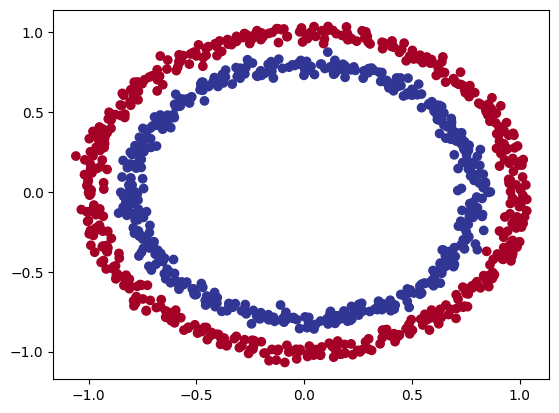

In [7]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

## Checking Input and Output shapes

In [8]:
X.shape,y.shape

((1000, 2), (1000,))

In [9]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [10]:
#viewing the first sample
X_sample= X[0]
y_sample = y[0]

print(X_sample, y_sample)
print(X_sample.shape,y_sample.shape)


[0.75424625 0.23148074] 1
(2,) ()


# Turning it into tensor

In [11]:
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

In [12]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [13]:
X_train, X_test, y_train, y_test=train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [15]:
#model building
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1=nn.Linear(in_features=2, out_features=5)
        self.layer_2=nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0=CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
#easier type
model_0= nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1913,  0.6541],
                      [ 0.3996, -0.2648],
                      [-0.6085,  0.2513],
                      [-0.0120,  0.3433],
                      [-0.3146, -0.5147]], device='cuda:0')),
             ('0.bias',
              tensor([-0.4899,  0.6992,  0.0020,  0.6141, -0.2006], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1520, -0.0129,  0.1490, -0.0397, -0.4464]], device='cuda:0')),
             ('1.bias', tensor([0.0543], device='cuda:0'))])

In [18]:
# Make predictions with the model
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.2867],
        [0.3367],
        [0.1244],
        [0.3329],
        [0.0745],
        [0.1053],
        [0.2855],
        [0.2312],
        [0.1267],
        [0.3395]], device='cuda:0')

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [19]:
#Setting up the loss fn and optimizers

In [20]:
loss_fn= nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                           lr=0.1)

In [3]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc= (correct/len(y_pred)) * 100
    return acc

# Training loop


In [22]:
with torch.inference_mode():
    y_logits=model_0(X_test.to(device))[:5]
y_logits

tensor([[0.2867],
        [0.3367],
        [0.1244],
        [0.3329],
        [0.0745]], device='cuda:0')

In [23]:
y_pred_prob= torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.5712],
        [0.5834],
        [0.5310],
        [0.5825],
        [0.5186]], device='cuda:0')

In [24]:
y_preds = torch.round(y_pred_prob)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs= 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze() 
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred = y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, 
                           y_test)
        test_acc = accuracy_fn(y_true=y_test, 
                              y_pred = test_pred)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69769, Acc: 50.00% | Test loss: 0.70215, Test acc: 50.00%
Epoch: 10 | Loss: 0.69477, Acc: 54.62% | Test loss: 0.69907, Test acc: 50.50%
Epoch: 20 | Loss: 0.69384, Acc: 52.38% | Test loss: 0.69786, Test acc: 48.50%
Epoch: 30 | Loss: 0.69350, Acc: 51.88% | Test loss: 0.69725, Test acc: 49.00%
Epoch: 40 | Loss: 0.69335, Acc: 51.25% | Test loss: 0.69685, Test acc: 48.50%
Epoch: 50 | Loss: 0.69326, Acc: 51.62% | Test loss: 0.69655, Test acc: 48.00%
Epoch: 60 | Loss: 0.69320, Acc: 51.00% | Test loss: 0.69631, Test acc: 48.00%
Epoch: 70 | Loss: 0.69316, Acc: 51.12% | Test loss: 0.69610, Test acc: 46.50%
Epoch: 80 | Loss: 0.69312, Acc: 50.75% | Test loss: 0.69593, Test acc: 46.50%
Epoch: 90 | Loss: 0.69309, Acc: 51.00% | Test loss: 0.69577, Test acc: 47.50%


In [4]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [27]:
# Make predictions
model_0.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 1., 0., 1., 0., 0., 1., 1., 0., 1.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

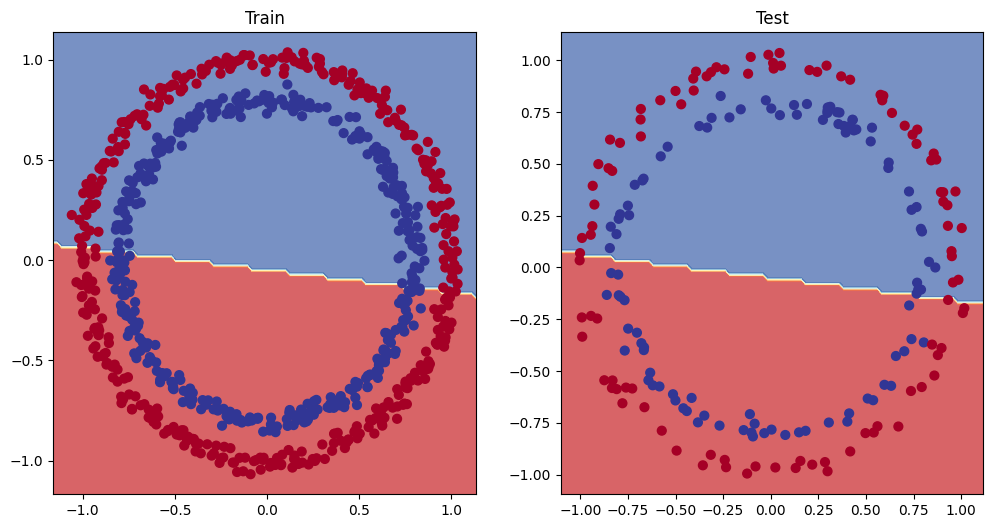

In [28]:
plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# We need non linearity here

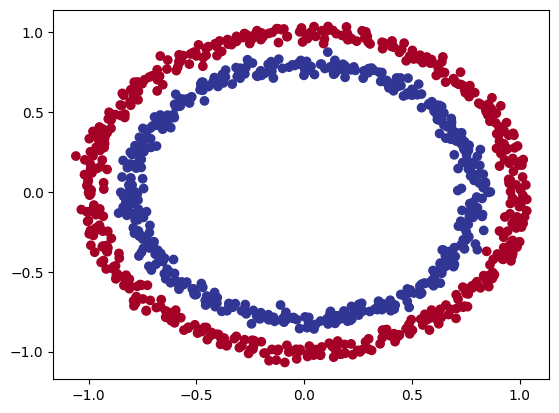

In [45]:
ns=1000
X, y = make_circles(ns, 
                   noise= 0.03, 
                   random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [46]:
X= torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y, 
                                                   test_size= 0.2, 
                                                   random_state= 42)


In [47]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [48]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [49]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 2000 | Loss: 0.04176, Accuracy: 99.88% | Test Loss: 0.06583, Test Accuracy: 100.00%
Epoch: 3000 | Loss: 0.01672, Accuracy: 99.88% | Test Loss: 0.03363, Test Accuracy: 100.00%
Epoch: 4000 | Loss: 0.01048, Accuracy: 100.00% | Test Loss: 0.02451, Test Accuracy: 99.50%
Epoch: 5000 | Loss: 0.00765, Accuracy: 100.00% | Test Loss: 0.01993, Test Accuracy: 99.50%
Epoch: 6000 | Loss: 0.00603, Accuracy: 100.00% | Test Loss: 0.01726, Test Accuracy: 99.50%
Epoch: 7000 | Loss: 0.00499, Accuracy: 100.00% | Test Loss: 0.01557, Test Accuracy: 99.50%
Epoch: 8000 | Loss: 0.00428, Accuracy: 100.00% | Test Loss: 0.01451, Test Accuracy: 99.50%
Epoch: 9000 | Loss: 0.00375, Accuracy: 100.00% | Test Loss: 0.01374, Test Accuracy: 99.50%


In [50]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

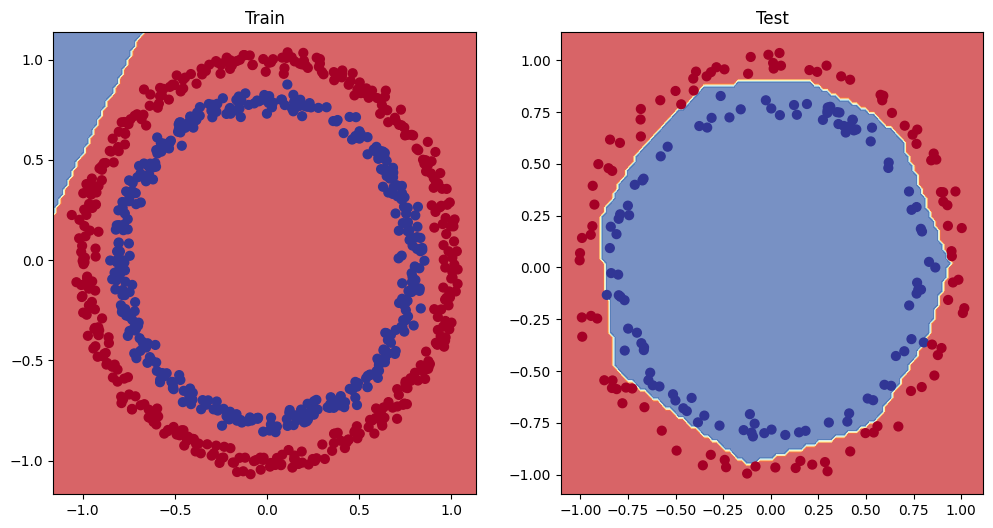

In [51]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

In [4]:
#Multiclass Classification

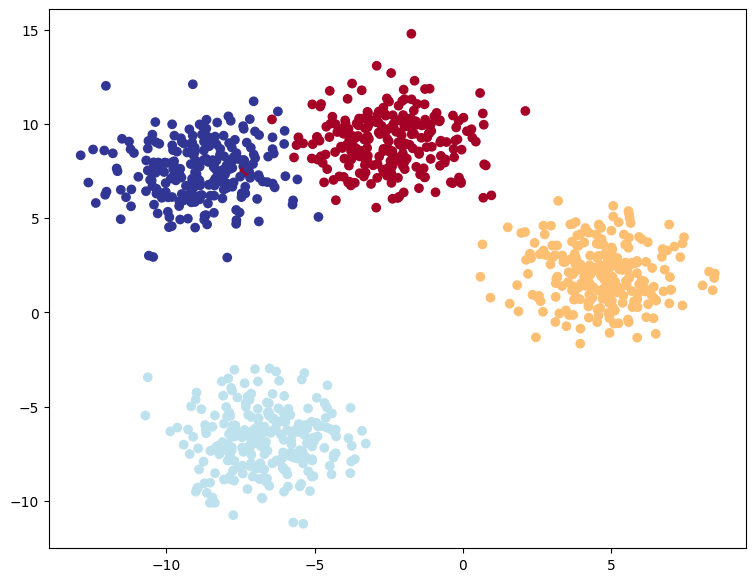

In [5]:
from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples= 1000, 
                           n_features= NUM_FEATURES,
                            centers=NUM_CLASSES,
                           cluster_std=1.5,
                           random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, 
                                                                       y_blob, 
                                                                       test_size=0.2,
                                                                       random_state=RANDOM_SEED)

plt.figure(figsize=(9, 7))
plt.scatter(X_blob[:, 0],X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [6]:
device

'cuda'

In [7]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                   output_features=4,
                   hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [8]:

X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [9]:

torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [10]:

# Create a loss function for multi-class classification - loss function measures how wrong our model's predictions are
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(), 
                            lr=0.1) # learning rate is a hyperparameter you can change
     

In [11]:

# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[ 1.2715,  0.2134,  0.4869,  0.4452],
        [-0.6544, -0.7628,  0.5203,  0.4008],
        [-2.1830, -1.1619, -0.8757, -1.3576],
        [ 0.6876,  0.0086,  0.1519,  0.0137],
        [ 1.1326,  0.0187,  0.9600,  1.0122],
        [-0.8409, -0.8744,  0.5880,  0.4746],
        [-1.9504, -1.0337, -0.9185, -1.3992],
        [ 0.6352, -0.1939,  0.8190,  0.8195],
        [-2.6565, -1.3962, -0.8892, -1.3948],
        [ 0.8002, -0.1203,  0.8540,  0.8692]], device='cuda:0')

In [12]:
y_preds_probs=torch.softmax(y_logits, dim=1)
y_preds_probs[:5]

tensor([[0.4462, 0.1549, 0.2036, 0.1953],
        [0.1249, 0.1121, 0.4043, 0.3588],
        [0.1025, 0.2846, 0.3789, 0.2340],
        [0.3843, 0.1949, 0.2249, 0.1959],
        [0.3272, 0.1074, 0.2753, 0.2901]], device='cuda:0')

In [13]:
y_preds=torch.argmax(y_preds_probs, dim=1)
y_preds[:5]

tensor([0, 2, 2, 0, 0], device='cuda:0')

# Training and Testing loop

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss= loss_fn(y_logits, y_blob_train)
    acc= accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



    #testing

    model_4.eval()
    with torch.inference_mode():
        test_logits= model_4(X_blob_test)
        test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                              y_pred=test_preds)

    if epoch % 10==0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f} , Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.2709 , Acc: 28.50% | Test loss: 0.7058, test acc: 74.00%
Epoch: 10 | Loss: 0.1681 , Acc: 99.12% | Test loss: 0.1512, test acc: 99.50%
Epoch: 20 | Loss: 0.0887 , Acc: 99.12% | Test loss: 0.0802, test acc: 99.50%
Epoch: 30 | Loss: 0.0634 , Acc: 99.12% | Test loss: 0.0557, test acc: 99.50%
Epoch: 40 | Loss: 0.0515 , Acc: 99.12% | Test loss: 0.0438, test acc: 99.50%
Epoch: 50 | Loss: 0.0448 , Acc: 99.12% | Test loss: 0.0368, test acc: 99.50%
Epoch: 60 | Loss: 0.0404 , Acc: 99.12% | Test loss: 0.0323, test acc: 99.50%
Epoch: 70 | Loss: 0.0375 , Acc: 99.12% | Test loss: 0.0291, test acc: 99.50%
Epoch: 80 | Loss: 0.0353 , Acc: 99.12% | Test loss: 0.0268, test acc: 99.50%
Epoch: 90 | Loss: 0.0337 , Acc: 99.12% | Test loss: 0.0250, test acc: 99.50%


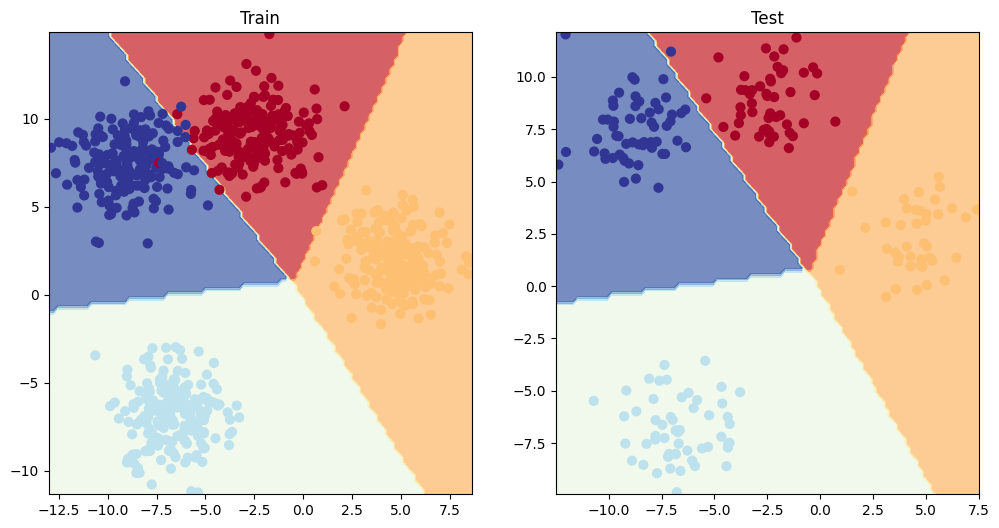

In [15]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train) 
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)